In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'figure.figsize': [15, 7.5], 'font.size': 30,
                            'axes.titlesize' : 34, 'axes.labelsize' : 30,
                            'lines.linewidth' : 5, 'lines.markersize' : 10,
                            'xtick.labelsize' : 24, 'ytick.labelsize' : 24})

In [2]:
def load_data_MNTest(fl="./src/MCTestData.csv"):
    """
    Loads data stored in McNemarTest.csv
    :param fl: filename of csv file
    :return: labels, prediction1, prediction2
    """
    data = pd.read_csv(fl, header=None).to_numpy()
    labels= data[:, 0]
    prediction_1 = data[:, 1]
    prediction_2 = data[:, 2]
    return labels, prediction_1,prediction_2

In [3]:
# McNemar Test
print("H0: both models have the same performance")
print("H1: performances of the two models are not equal")
chi2_095 = stats.chi2.ppf(0.95, 1)
labels, prediction_1,prediction_2 = load_data_MNTest()

A = np.sum((prediction_1 != labels) & (prediction_2 != labels))
B = np.sum((prediction_1 != labels) & (prediction_2 == labels))
C = np.sum((prediction_1 == labels) & (prediction_2 != labels))
D = np.sum((prediction_1 == labels) & (prediction_2 == labels))

print("A:"+str(A))
print("B:"+str(B))
print("C:"+str(C))
print("D:"+str(D))
print("Error of model 1:{:.4f}".format((A+B)/(A+B+C+D)))
print("Error of model 2:{:.4f}".format((A+C)/(A+B+C+D)))
chi2_Mc = (abs(B-C)-1)**2/(B+C)
if chi2_Mc > chi2_095:
    print("The chi2_Mc value is {:.3f}, greater than the default value {:.3f}, we reject the hypothesis H0".format(chi2_Mc, chi2_095))


H0: both models have the same performance
H1: performances of the two models are not equal
A:107
B:65
C:93
D:235
Error of model 1:0.3440
Error of model 2:0.4000
The chi2_Mc value is 4.614, greater than the default value 3.841, we reject the hypothesis H0


In [4]:
def load_data_TMStTest(fl="./src/TMStTestData.csv"):
    """
    Loads data stored in fl
    :param fl: filename of csv file
    :return: y1, y2
    """
    data = np.loadtxt(fl, delimiter=",")
    y1 = data[:, 0]
    y2 = data[:, 1]
    return y1, y2

In [5]:
# Two-Matched-Samples t-Test
y1, y2 = load_data_TMStTest()

print("H0: the model 1 and 2 perform equally well")
print("H1: performance of the two models are not equal")

diff = y1-y2
diff_mean = np.mean(diff)
sigma_d = np.sqrt(np.sum((diff-diff_mean)**2)/(len(diff)-1))

t = np.sqrt(len(diff)) * diff_mean/sigma_d

df = len(y1) + len(y2)
p = stats.t.sf(np.abs(t), len(diff)-1)*2

print("t-value:"+str(t))
print("p-value:"+str(p))
print("The p-value is {:4f} < 0.05, thus we reject the hypothesis".format(p))

H0: the model 1 and 2 perform equally well
H1: performance of the two models are not equal
t-value:-8.923519540749611
p-value:1.4330419155090628e-17
The p-value is 0.000000 < 0.05, thus we reject the hypothesis


In [6]:
def load_data_FTest(fl="./src/FTestData.csv"):
    """
    Loads data stored in fl
    :param fl: filename of csv file
    :return: evaluations
    """
    errors = np.loadtxt(fl, delimiter=",")
    return errors

In [7]:
# Freidman Test

print("H0: all algorithms are equivalent in their performance and hence their average ranks should be equal")
print("H1: the average ranks for at least one algorithm is different")

errors = load_data_FTest()

FData_stats={'errors':errors}

n = errors.shape[0]
k = errors.shape[1]

r = stats.mstats.rankdata(errors, axis=1)

r_mean_all = np.mean(r)
r_mean_models = np.mean(r, axis=0)

ss_total = n * np.sum((r_mean_models-r_mean_all)**2)
ss_error = np.sum((r_mean_all-r)**2)/(n*(k-1))

chi2_F = ss_total/ss_error
chi2_095 = stats.chi2.ppf(0.95, k-1)
if chi2_F > chi2_095:
    print("the chi2_F value is {:.4f}, greater than chi2_095 value {:.4f}, we reject the hypothesis H0".
          format(chi2_F, chi2_095))
    
FData_stats.update({'ranking_models':r_mean_models,
                    'n':n,
                    'k':k})

H0: all algorithms are equivalent in their performance and hence their average ranks should be equal
H1: the average ranks for at least one algorithm is different
the chi2_F value is 18.1333, greater than chi2_095 value 9.4877, we reject the hypothesis H0


In [8]:
# Post-hoc Nemenyi test

k = FData_stats['k']
n = FData_stats['n']

r_expand_h = np.repeat(np.expand_dims(FData_stats['ranking_models'], axis=1), k, axis=1)
r_expand_v = np.repeat(np.expand_dims(FData_stats['ranking_models'], axis=0), k, axis=0)
q = np.triu((r_expand_h-r_expand_v)/np.sqrt(k*(k+1)/(6*n)))
print("the Q matrix is as follows:")
print(q)

the Q matrix is as follows:
[[ 0.          0.92376043  3.92598183  1.84752086  0.80829038]
 [ 0.          0.          3.0022214   0.92376043 -0.11547005]
 [ 0.          0.          0.         -2.07846097 -3.11769145]
 [ 0.          0.          0.          0.         -1.03923048]
 [ 0.          0.          0.          0.          0.        ]]


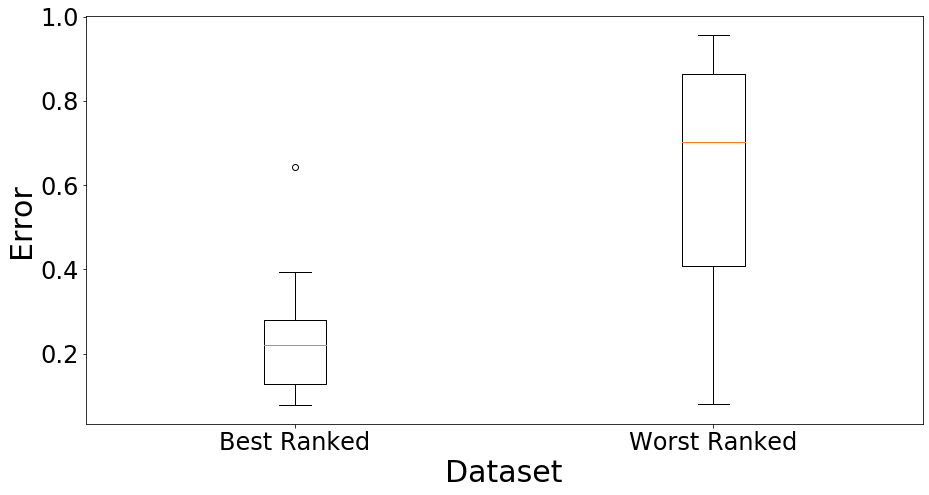

In [9]:
# boxplot

idx_best = np.argmin(FData_stats['ranking_models'])
idx_worst = np.argmax(FData_stats['ranking_models'])

plt.boxplot([FData_stats['errors'][:, idx_best], FData_stats['errors'][:, idx_worst]], labels=["Best Ranked", "Worst Ranked"])
plt.ylabel("Error")
plt.xlabel("Dataset")
plt.show()